<a href="https://colab.research.google.com/github/Jeremstar/ca-va-predire-l-inflation-severe/blob/main/Copie_de_notebook_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 5.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import requests

In [ ]:
OECD = pd.read_excel('données/OECD - short term economic indicators.xlsx')
IMF = pd.read_excel('données/IMF - monetary policy.xlsx')

In [ ]:
Enq13 = pd.read_excel('https://www.newyorkfed.org/medialibrary/interactives/sce/sce/downloads/data/frbny-sce-public-microdata-complete-13-16.xlsx')

In [ ]:
Enq17 = pd.read_excel('https://www.newyorkfed.org/medialibrary/interactives/sce/sce/downloads/data/frbny-sce-public-microdata-complete-17-19.xlsx')

In [ ]:
#Il faut faire 2-3 manips pour rendre les bases utilisables
new_columns = Enq13.iloc[0]
Enq13.columns = new_columns
Enq13 = Enq13.drop(0)

new_columns = Enq17.iloc[0]
Enq17.columns = new_columns
Enq17 = Enq17.drop(0)

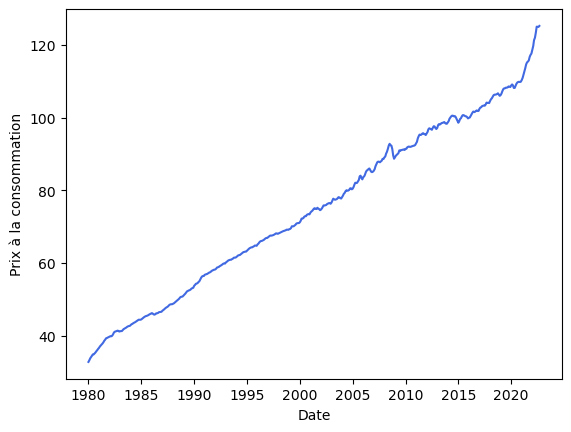

5.046825948510132

In [ ]:
#Graphique d'indice des prix à la consommation

inflation_US = OECD[(OECD['Country'] == "United States") & (OECD['Subject2'] == "Consumer prices: all items")]
inflation_US2 = pd.DataFrame({
    'day': pd.to_datetime(inflation_US['Time'], format='%Y-%m-%d'),
    'Inflation': inflation_US['Value'].astype(float)
})

plt.plot(inflation_US2['day'], inflation_US2['Inflation'], color='royalblue')
plt.xlabel('Date')
plt.ylabel("Prix à la consommation")
plt.show()

Enq17['Q8v2part2'].mean(skipna=True)


In [ ]:
#Calcul du taux d'inflation

inflation_US3 = pd.DataFrame({
    'date': inflation_US2['day'],
    'tx_evol_ann_pct': (inflation_US2['Inflation'] / inflation_US2['Inflation'].shift(12) - 1) * 100
})

In [ ]:
#Conversion des formats null en date

Enq17['date'] = pd.to_datetime(Enq17['date'].astype(str) + '01', format='%Y%m%d')
Enq13['date'] = pd.to_datetime(Enq13['date'].astype(str) + '01', format='%Y%m%d')

In [ ]:
def mean_group_date(DF,arg):
    list_date = DF['date']
    list_date_e = []
    for d in list_date :
        if d not in list_date_e:
            list_date_e.append(d)

    list_mean_e = [DF.groupby('date')[arg].get_group(d).mean() for d in list_date_e]

    return pd.DataFrame(np.array(list_mean_e),index=list_date_e,columns=[arg])


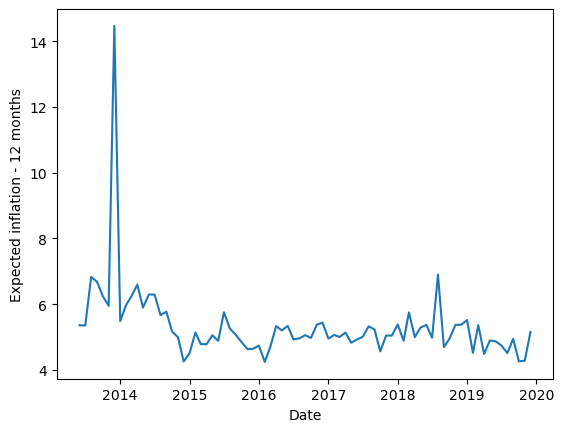

In [ ]:
#Graphique des anticipations d'inflation à court terme

anticipations_short_13 = mean_group_date(Enq13,'Q8v2part2')#.reset_index
anticipations_short_17 = mean_group_date(Enq17,'Q8v2part2')#.reset_index
anticipations_short = pd.concat([anticipations_short_13, anticipations_short_17]).reset_index().rename(columns={'index':'date','Q8v2part2':'anticipation'})

plt.plot(anticipations_short['date'], anticipations_short['anticipation'])
plt.xlabel('Date')
plt.ylabel("Expected inflation - 12 months")
plt.show()


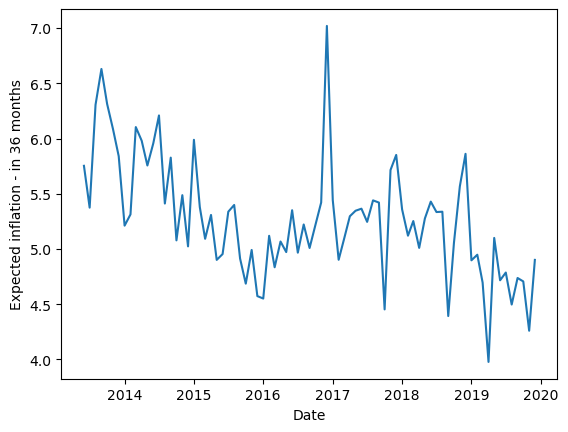

In [ ]:
#Graphique des anticipations d'inflation à moyen terme

anticipations_mid_13 = mean_group_date(Enq13,'Q9bv2part2')
anticipations_mid_17 = mean_group_date(Enq17,'Q9bv2part2')
anticipations_mid = pd.concat([anticipations_mid_13, anticipations_mid_17]).reset_index().rename(columns={'index':'date','Q9bv2part2':'anticipation'})

plt.plot(anticipations_mid['date'], anticipations_mid['anticipation'])
plt.xlabel('Date')
plt.ylabel("Expected inflation - in 36 months")
plt.show()



In [ ]:

#Comparaison pour du court terme

comp_infl_short = pd.merge(inflation_US3, anticipations_short, on='date')
comp_infl_short['expected']=comp_infl_short['anticipation'].shift(12)
comp_infl_short['dif'] = comp_infl_short['expected'] - comp_infl_short['tx_evol_ann_pct']


import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

plt.figure(figsize=(15,5))
plt.plot(comp_infl_short['date'],comp_infl_short['expected'],color='blue',label='Expected')
plt.plot(comp_infl_short['date'],comp_infl_short['tx_evol_ann_pct'],color='red',label='Real')
plt.ylabel('Inflation rate')
plt.xlabel('date')
plt.title('Comparison inflation anticipée à m-12 et inflation réalisée')
plt.legend()
plt.xlim(pd.to_datetime('2014-05-01'),pd.to_datetime('2020-01-01'))
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.show()


KeyError: 'name'

In [ ]:
#comp_infl_short.head(2)
inflation_US3.tail(10)

,date,tx_evol_ann_pct
112422,2021-12-01,7.036403
112423,2022-01-01,7.479872
112424,2022-02-01,7.871064
112425,2022-03-01,8.542456
112426,2022-04-01,8.258629
112427,2022-05-01,8.581512
112428,2022-06-01,9.059758
112429,2022-07-01,8.524815
112430,2022-08-01,8.262693
112431,2022-09-01,8.201670


In [ ]:
#Comparaison pour du moyen terme

fig = plt.figure()
comp_infl_mid = pd.merge(inflation_US3, anticipations_mid, on='date')
comp_infl_mid['expected'] = comp_infl_mid['anticipation'].shift(36)
comp_infl_mid['dif'] = comp_infl_mid['expected'] - comp_infl_mid['tx_evol_ann_pct']

plt.plot(comp_infl_mid['date'], comp_infl_mid['expected'], color='blue', label='Expected')
plt.plot(comp_infl_mid['date'], comp_infl_mid['tx_evol_ann_pct'], color='red', label='Real')
plt.xlabel('Date')
plt.ylabel("Inflation rate")
plt.xlim(pd.to_datetime('2016-05-01'),pd.to_datetime('2020-01-01'))
plt.title("Comparaison inflation anticipée à m-36 et inflation réalisée")
plt.legend()
plt.show()

KeyError: 'name'